In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import warnings
data = pd.read_csv('https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/arima_data.csv', names =['day', 'price'])
data.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [28]:
data['day'] = pd.to_datetime(data['day'],format = '%Y-%m-%d')
data.set_index('day', inplace = True)
data.head()

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


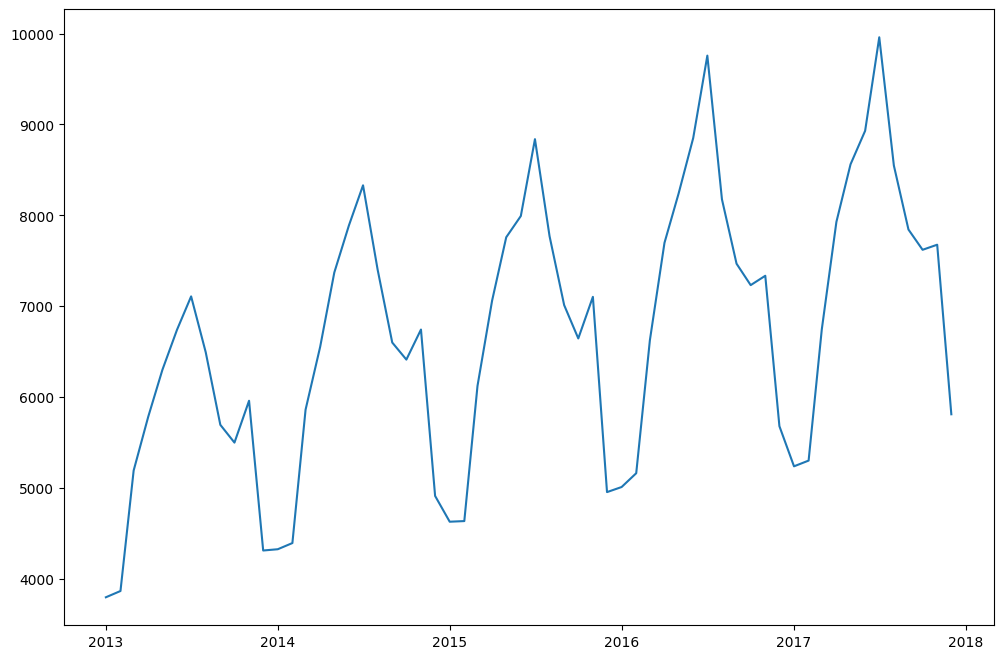

In [30]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])
#추세에 따라 계절성이 존재하는 것을 볼수 있고 시간이 지남에 따라 커지므로 Multiplicative를 적용하여 시계열 분해해야됨

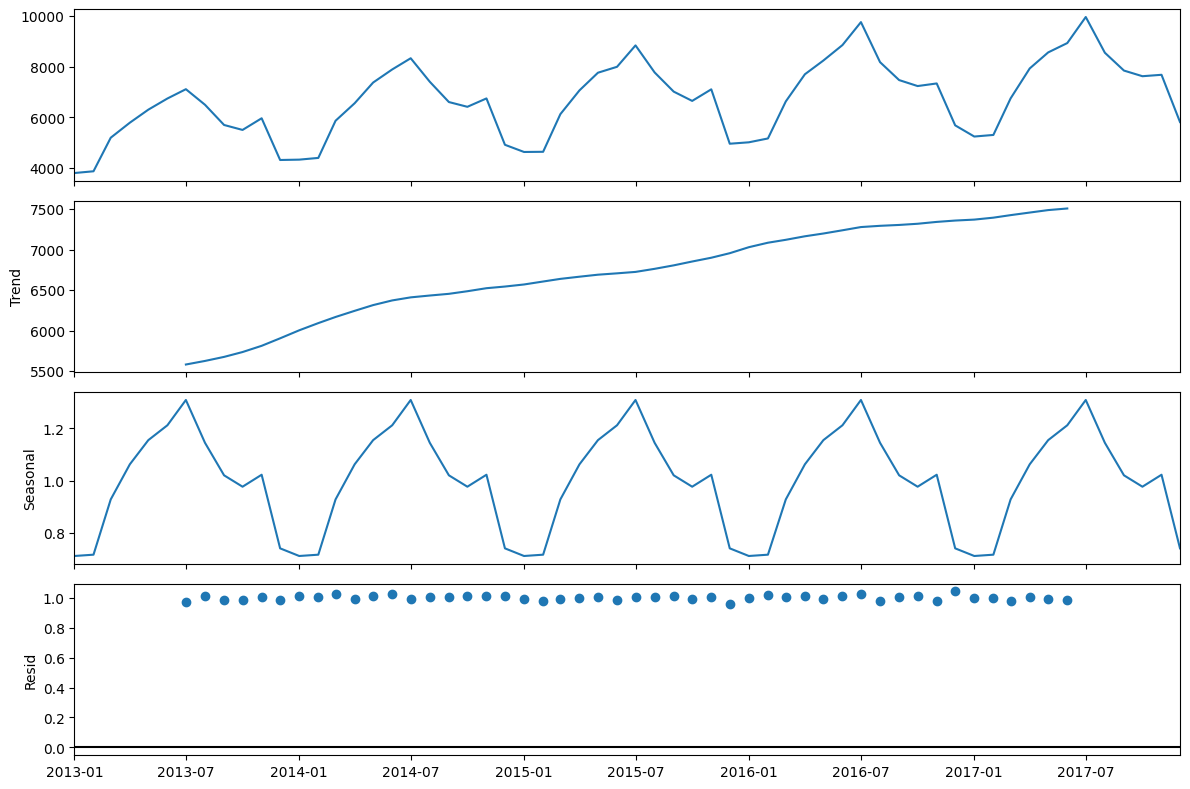

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result =seasonal_decompose(ts, model = 'multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller

training = data[: '2016-12-01']
test = data.drop(training.index)

adf = adfuller(training, regression = 'ct')
print('ADP Statistic: {}'.format(adf[0]))
print('P-value : {}'.format(adf[1])) # 귀무가설: 정상성을 갖지 않는다. 연구가설: 정상성을 갖는다.  P-value : 0.601586330379429 로 귀무가설 채택

ADP Statistic: -1.9997199341327594
P-value : 0.601586330379429


<Axes: xlabel='day'>

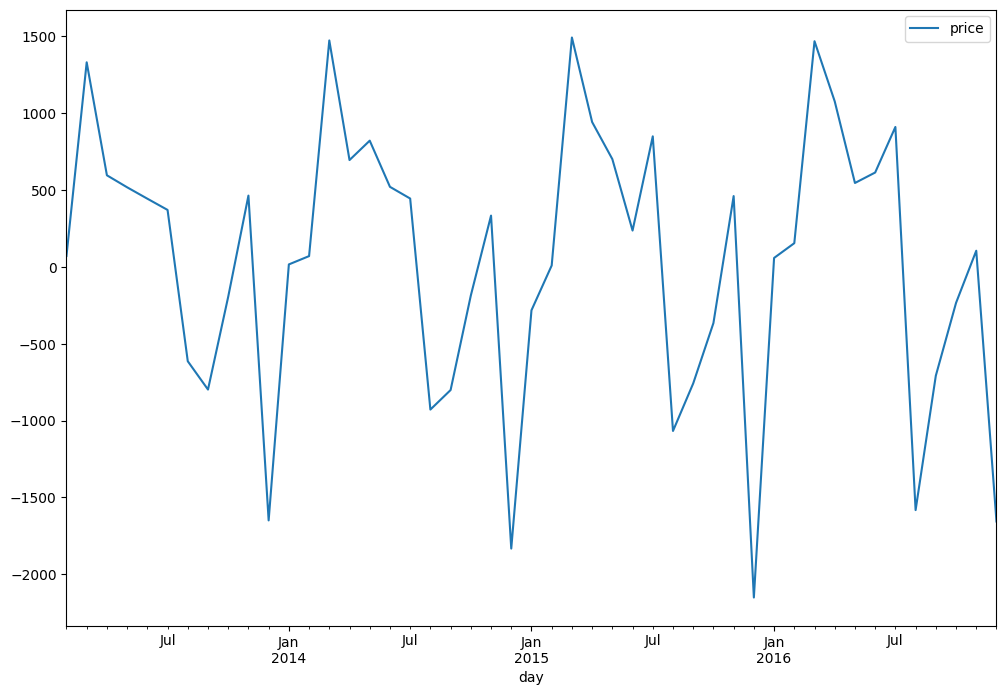

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 정상성을 갖지 않으므로 차분 또는 로그변환이 필요함

diff_data = training.diff(1)
diff_data = diff_data.dropna()
diff_data.plot()

In [34]:
adf = adfuller(diff_data)
print('ADP Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1])) # 1차 차분후 2.085160639961322e-22으로 0.05보다 작으므로 정상성을 가니다. 연구가설 채택

ADP Statistic: -12.094547576926397
p-value : 2.085160639961322e-22


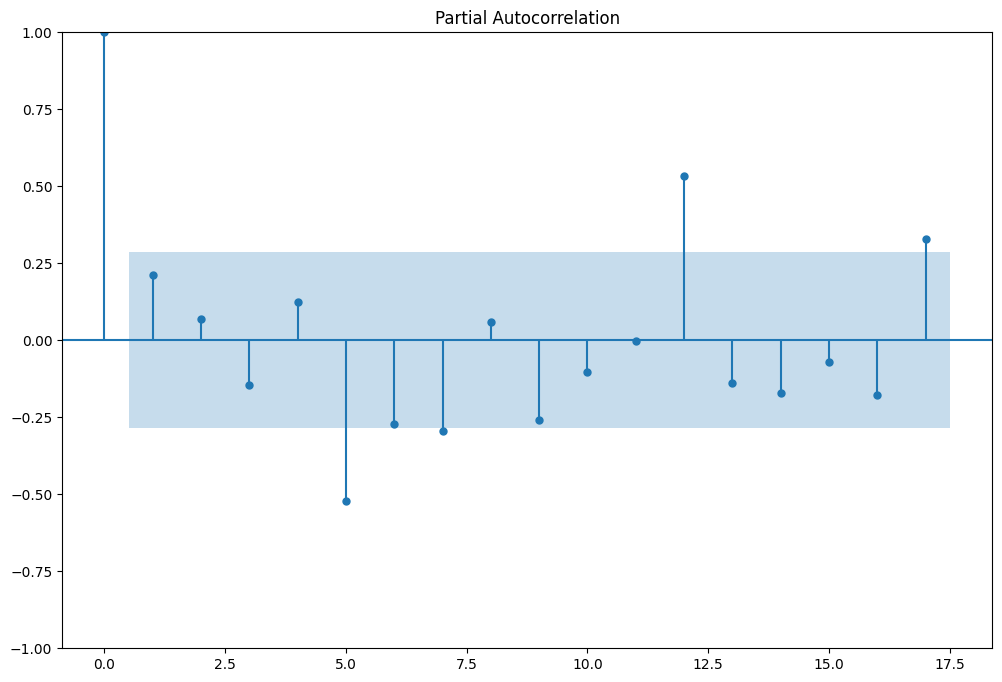

In [35]:
#AR 모형 자기회귀
plot_pacf(diff_data)
plt.show()

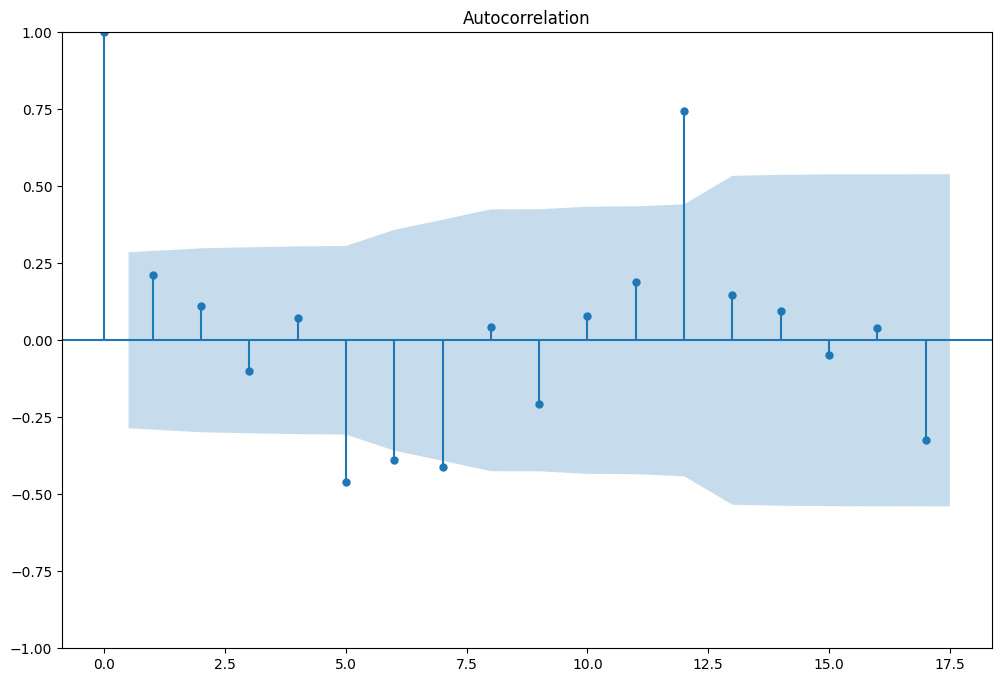

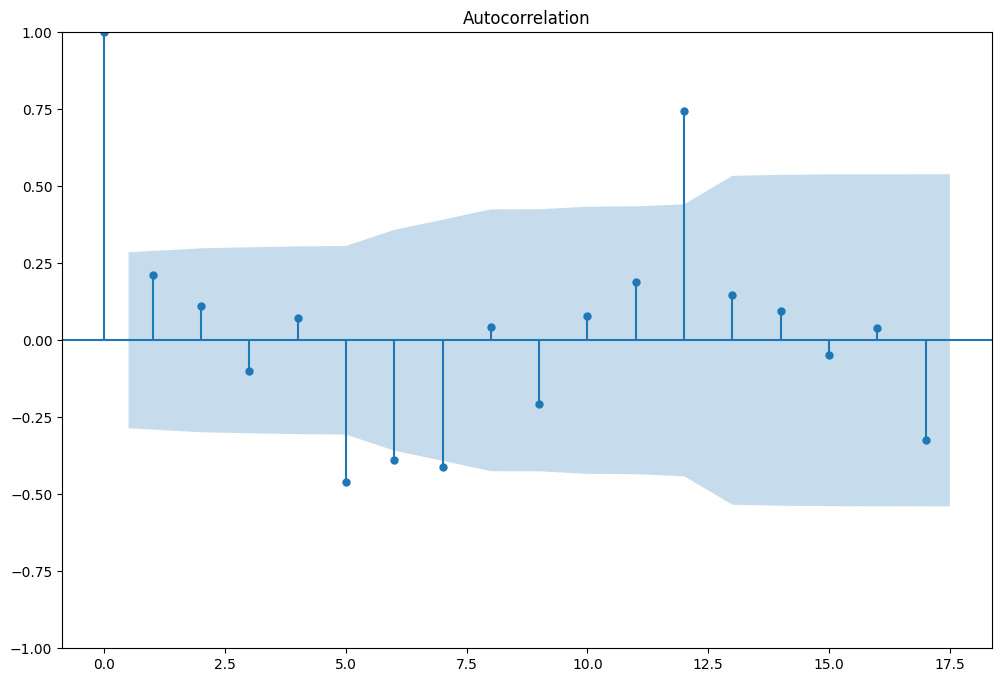

In [36]:
#MA 이동평균모형 ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(diff_data)


정규성 검정 (Jarque-Bera):

Jarque-Bera (JB) 검정은 잔차가 정규분포를 따르는지 여부를 평가하는데 사용됩니다.
여기서 JB 값이 0.38이며, p-value (Prob(JB))가 0.83로 나타남.
일반적으로 p-value가 0.05보다 크면, 잔차는 정규분포를 따른다고 판단됨. 따라서 여기서는 잔차가 정규성 가정을 충족한다고 할 수 있음.

잔차 분석 (Ljung-Box):

Ljung-Box 검정은 잔차의 자기상관성을 평가하는데 사용됨.
여기서 Ljung-Box (L1) 검정 결과인 Q 값이 0.11이며, p-value (Prob(Q))가 0.74로 나타남.
Q 값이 작고, p-value가 0.05보다 크면, 잔차는 자기상관성이 없다고 판단됨. 따라서 여기서는 잔차의 자기상관성이 없다고 할 수 있음.

성능 평가 지표 (AIC, BIC, HQIC):

AIC, BIC, HQIC는 모델의 성능을 평가하기 위한 지표임.
AIC 값은 761.750, BIC 값은 771.001, HQIC 값은 765.231임.
이 중에서는 AIC와 BIC가 모델의 성능을 나타내는데 사용됩니다. 일반적으로 이 값들이 낮을수록 모델의 성능이 더 좋다고 판단됨. 여기서는 모델의 성능이 어느 정도 향상된 것으로 보임.

Heteroskedasticity (이분산성):

이분산성 검정 결과로, Prob(H) (two-sided)가 0.44로 나타남.
여기서는 이분산성에 대한 검정 결과로, 이분산성이 없다고 할 수 있음.
종합적으로, 주어진 SARIMAX 모델의 잔차는 정규성 가정을 충족하며, 자기상관성이 없는 것으로 나타남. 또한 AIC 및 BIC 값이 낮아지면서 모델의 성능이 향상된 것으로 판단됨. 이분산성은 없는 것으로 확인되었음. 따라서 이 모델은 데이터에 대해 상당히 적합하고, 잔차 분석 결과도 양호한 것으로 평가됨.

# ARIMA

In [37]:
#ARIMA 비정상시계열자료 분석 모형
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training, order = (2, 1, 2)) # (p, d, q)
res = model.fit()
res.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Tue, 21 Nov 2023   AIC                            761.750
Time:                        20:11:16   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3167      0.190     -6.940      0.000      -1.689      -0.945
ar.L2         -0.3191      0.190     -1.675      0.094      -0.692       0.054
ma.L1          1.9700      0.243      8.121      0.000       1.495       2.445
ma.L2          0.9950      0.241      4.126      0.000       0.522       1.468
sigma2      4.453e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.74e+27. Standard errors may be unstable.
"""

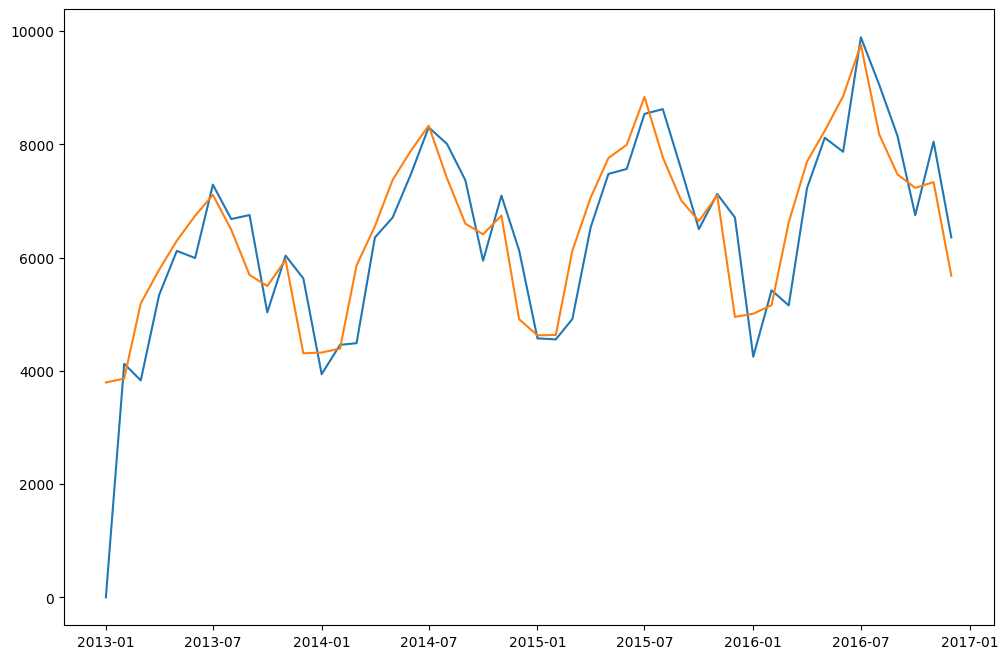

In [38]:
plt.plot(res.predict()) #모델 예측
plt.plot(training)


In [39]:
forecast_data = res.forecast(steps = len(test), alpha = 0.05)
pred_y = forecast_data
pred_y

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2017-01-01    5830.560146
2017-02-01    5508.376754
2017-03-01    5883.921927
2017-04-01    5492.240862
2017-05-01    5888.140676
2017-06-01    5491.834906
2017-07-01    5887.329001
2017-08-01    5493.033200
2017-09-01    5886.010183
2017-10-01    5494.387346
2017-11-01    5884.647980
2017-12-01    5495.748885
Freq: MS, Name: predicted_mean, dtype: float64

In [40]:
test_y = test
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


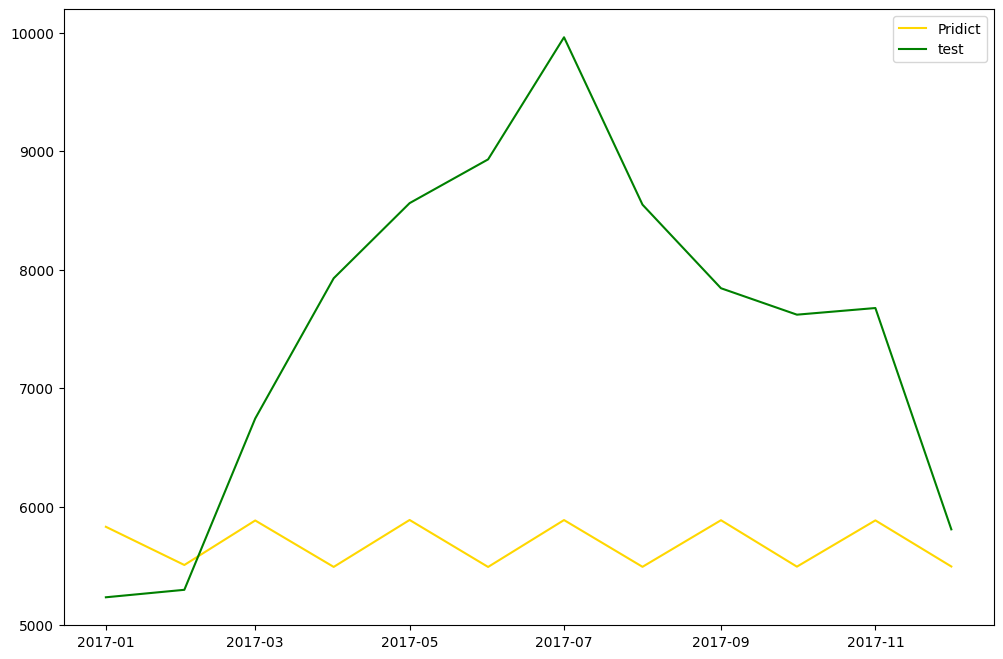

In [41]:
plt.plot(pred_y, color = 'gold', label = 'Pridict')
plt.plot(test_y, color = 'green', label = 'test')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('r2_score', r2_score(test_y, pred_y))
RMSE = mean_squared_error(test_y, pred_y)**0.5
print('RMSE:', RMSE) #r2_score -1.6430396460564052 로 정확도가 매우 안좋음 따라서 계절성이 있는 SARIMA 모델을 수행한다.

r2_score -1.6430396460564052
RMSE: 2302.26085893071


#SARIMA 계절성까지 고려한 ARIMA 모형

In [43]:
!pip install pmdarima

In [44]:
from pmdarima import auto_arima
auto_model = auto_arima(training, start_p = 0, d = 1, start_q = 0,
                        max_p = 3, max_q = 3,
                        start_P = 0, start_Q=0,
                        max_P=3, max_Q=3, m = 12,
                        seasonal= True, information_criterion = 'aic',
                        trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.54 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

ma.L1 (Moving Average, Lag 1):

ma.L1은 이동평균 모델의 1차 이동평균 항목에 대한 계수임.
t-statistic은 -1.801이며, p-value는 0.072입니다.
p-value가 0.05보다 크므로, 이 ma.L1 매개변수는 통계적으로 유의미하지 않다고 할 수 있음. 즉, 이동평균 모델의 1차 항목은 종속 변수에 대해 유의미한 영향을 미치지 않을 가능성이 높음.
sigma2

(Residual Variance):

sigma2는 잔차의 분산을 나타내는 매개변수임.
t-statistic은 2.924이며, p-value는 0.003임.
p-value가 0.05보다 작으므로, sigma2 매개변수는 통계적으로 유의미함. 이는 잔차의 분산이 통계적으로 유의미한 변화를 보인다는 것을 의미함

요약하면, 주어진 SARIMAX 모델에서는 sigma2 매개변수가 통계적으로 유의미하며, 이동평균 모델의 1차 항목을 나타내는 ma.L1 매개변수는 통계적으로 유의미하지 않음. 따라서 잔차의 분산에 관련된 sigma2 매개변수가 유의미하다고 할 수 있음.

In [45]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Tue, 21 Nov 2023   AIC                            480.687
Time:                                     20:11:29   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

정규성 검정 (Jarque-Bera):

Jarque-Bera (JB) 검정은 잔차가 정규분포를 따르는지 여부를 평가하는데 사용됩니다.
여기서 JB 값이 0.38이며, p-value (Prob(JB))가 0.83로 나타남.
일반적으로 p-value가 0.05보다 크면, 잔차는 정규분포를 따른다고 판단됨. 따라서 여기서는 잔차가 정규성 가정을 충족한다고 할 수 있음.

잔차 분석 (Ljung-Box):

Ljung-Box 검정은 잔차의 자기상관성을 평가하는데 사용됨.
여기서 Ljung-Box (L1) 검정 결과인 Q 값이 0.11이며, p-value (Prob(Q))가 0.74로 나타남.
Q 값이 작고, p-value가 0.05보다 크면, 잔차는 자기상관성이 없다고 판단됨. 따라서 여기서는 잔차의 자기상관성이 없다고 할 수 있음.

성능 평가 지표 (AIC, BIC, HQIC):

AIC, BIC, HQIC는 모델의 성능을 평가하기 위한 지표임.
AIC 값은 761.750, BIC 값은 771.001, HQIC 값은 765.231임.
이 중에서는 AIC와 BIC가 모델의 성능을 나타내는데 사용됨. 일반적으로 이 값들이 낮을수록 모델의 성능이 더 좋다고 판단됨. 여기서는 모델의 성능이 어느 정도 향상된 것으로 보임

Heteroskedasticity (이분산성):

이분산성 검정 결과로, Prob(H) (two-sided)가 0.44로 나타남.
여기서는 이분산성에 대한 검정 결과로, 이분산성이 없다고 할 수 있음.
종합적으로, 주어진 SARIMAX 모델의 잔차는 정규성 가정을 충족하며, 자기상관성이 없는 것으로 나타남. 또한 AIC 및 BIC 값이 낮아지면서 모델의 성능이 향상된 것으로 판단됨. 이분산성은 없는 것으로 확인되었음. 따라서 이 모델은 데이터에 대해 상당히 적합하고, 잔차 분석 결과도 양호한 것으로 평가됨

In [46]:
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods = len(test)),
                           index = test.index)
auto_pred_y.columns = ['predicted_price']
auto_pred_y

,predicted_price
day,
2017-01-01,5609.436979
2017-02-01,5761.436979
2017-03-01,7225.436979
2017-04-01,8298.436979
2017-05-01,8841.436979
2017-06-01,9452.436979
2017-07-01,10359.436979
2017-08-01,8777.436979
2017-09-01,8068.436979


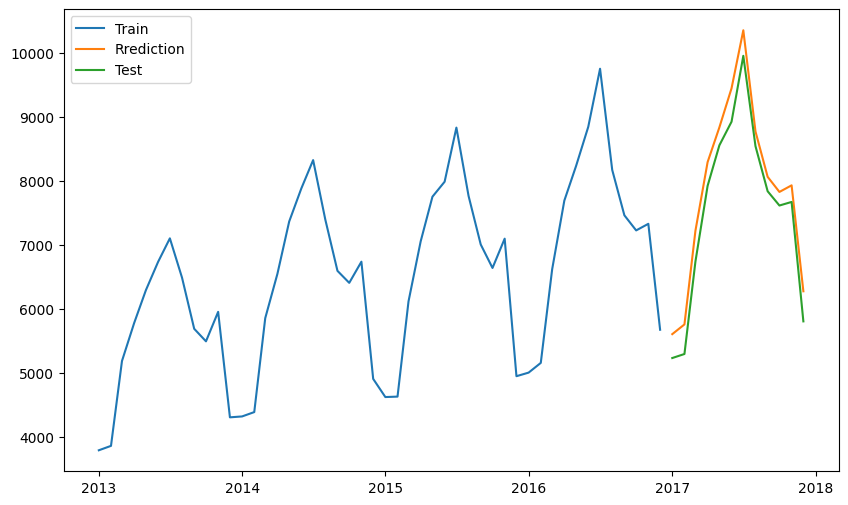

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(training, label = 'Train' )
plt.plot(auto_pred_y, label = 'Rrediction')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.show()


In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('r2_score', r2_score(test_y, auto_pred_y))
RMSE = mean_squared_error(test_y, auto_pred_y)**0.5
print('RMSE:', RMSE)

r2_score 0.9305467061841242
RMSE: 373.2064274724195


#VAR 다변량 회귀 시계열 모델

In [60]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# 임의의 다변량 시계열 데이터 생성
np.random.seed(123)
data = np.random.randn(100, 5)
x = data
test_y = x[-10:]

# 라그 수에 대한 범위 설정
max_lag = 10

# 최적의 라그 수를 찾기 위한 변수 초기화
best_lag = 0
best_mse = np.inf

# 그리드 서치
for lag in range(1, max_lag + 1):
    model = VAR(x)
    results = model.fit(lag)

    # 예측 생성 및 MSE 계산
    pred_y = results.forecast(x[-lag:], steps=10)
    mse = mean_squared_error(x[-10:], pred_y)

    # 최적의 라그 수 업데이트
    if mse < best_mse:
        best_mse = mse
        best_lag = lag

print(f"Best Lag: {best_lag}, Best MSE: {best_mse}")

Best Lag: 4, Best MSE: 0.9869793635041428


In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('r2_score', r2_score(test_y, pred_y))
RMSE = mean_squared_error(test_y, pred_y)**0.5
print('RMSE:', RMSE) # r2_score -0.6931388006157955 로 좋지 못한 모델임

r2_score -0.6931388006157955
RMSE: 1.3130552280374994


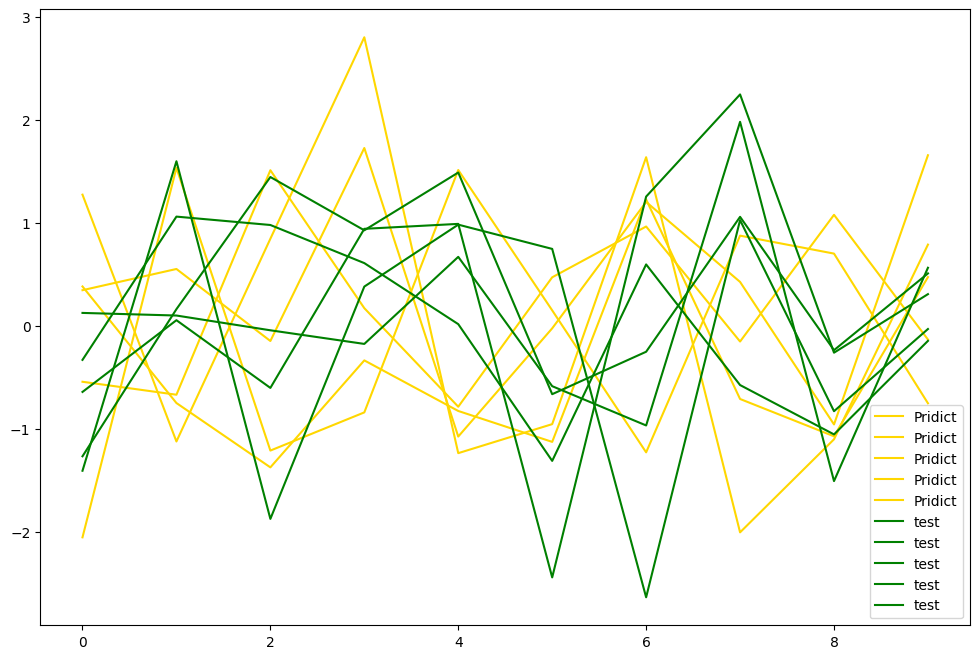

In [61]:
plt.plot(pred_y, color = 'gold', label = 'Pridict')
plt.plot(test_y, color = 'green', label = 'test')
plt.legend()
plt.show()

#교차검정

In [63]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# 교차 검증을 위한 설정
tscv = TimeSeriesSplit(n_splits=5)
# 교차 검증
for train_index, test_index in tscv.split(data):
    train, test = data[train_index], data[test_index]

    for lag in range(1, 11):  # 최대 10 라그
        model = VAR(train)
        results = model.fit(lag)

        # 예측 생성 및 MSE 계산
        pred_y = results.forecast(train[-lag:], steps=len(test))
        mse = mean_squared_error(test, pred_y)

        # 최적의 라그 수 업데이트
        if mse < best_mse:
            best_mse = mse
            best_lag = lag

# 최종 모델 훈련 및 성능 평가
final_model = VAR(data)
final_results = final_model.fit(best_lag)
final_pred_y = final_results.forecast(data[-best_lag:], steps=10)

# 성능 평가
mse = mean_squared_error(data[-10:], final_pred_y)
mae = mean_absolute_error(data[-10:], final_pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(data[-10:], final_pred_y)
print(f"Best Lag: {best_lag}, Final MSE: {mse}, MAE: {mae}, RMSE: {rmse}, r2: {r2}")

Best Lag: 1, Final MSE: 1.1249030047551902, MAE: 0.8511007708927881, RMSE: 1.0606144467973224, r2: -0.02650288915364891
